In [73]:
import h5py
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import pickle

In [ ]:
def read_ims(ims_path):
    with h5py.File(ims_path, 'r') as file:
        vol = file['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data'][:]
    return vol

# Read in the volume
vol_path = 'CM_10nM_RCA_2023-10-30_CM Alexa 565 brain slice_15.18.14.ims'
vol = read_ims(vol_path)
print('vol shape',vol.shape)

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(vol[20, :300, :300],vmax = 300)
# plt.show()

In [74]:
def find_puncta(vol, sigma=1, min_distance=5, threshold_abs=100):
    '''
    Finding puncta
    Inputs:
        vol: 3D numpy array
        sigma: float, smoothing parameter for gaussian filter
        min_distance: int, minimum distance between puncta
        threshold_abs: float, minimum absolute intensity for puncta
    '''
    # Smooth the volume
    vol_smooth = gaussian_filter(vol, sigma=sigma)
    # Find local maxima
    puncta = peak_local_max(vol_smooth, min_distance=min_distance, threshold_abs=threshold_abs)
    return puncta

def save_coords_as_pickle(coords, pickle_name):
    with open(pickle_name, 'wb') as f:
        pickle.dump(coords, f)

# Find puncta
small_vol = vol[:,:300,:300]
coords = find_puncta(small_vol,sigma = 0.5, min_distance=5, threshold_abs=100)

save_coords_as_pickle(coords, '10nM_coords.pkl')

In [ ]:
def plot_puncta_2d(coords, vol, z, z_span = 2, marker_size=10):
    '''
    Plot 2D image with puncta
    Inputs:
        z: int, z slice to plot
        coords: 2D numpy array, coordinates of puncta z,y,x
        vol: 3D numpy array, volume
        size: int, size of puncta
    '''
    coords = np.array([coord for coord in coords if z-z_span < coord[0] <z+z_span])
    plt.figure(figsize=(10,10))
    plt.imshow(vol[z,:,:], cmap='gray')
    plt.scatter(coords[:,2], coords[:,1], s=marker_size, c='r', marker='x')
    plt.title('z = {}'.format(z))
    plt.show()

# Plot puncta
z = 20
plot_puncta_2d(coords, small_vol, z=20, z_span = 2, marker_size=10)

In [81]:
def find_nearest_neighbor_and_distance(points):
    '''
    Find the nearest neighbor for each point
    Inputs:
        points: 2D numpy array, coordinates of points N x 3
    Outputs:
        nearest_neighbors: 2D numpy array, coordinates of nearest neighbors N x 3
        distances: 1D numpy array, distance between each point and its nearest neighbor N x 1
    '''
    
    # Convert pixel coords to ums
    points[:,0] =points[:,0]*0.4
    points[:,1] =points[:,1]*0.1625
    points[:,2] =points[:,2]*0.1625

    from scipy.spatial import cKDTree
    # Create a k-d tree from the points
    tree = cKDTree(points)

    # Find the nearest neighbor for each point
    nearest_neighbors = []
    for point in points:
        # Find the distances and locations of the nearest neighbors
        # k=2 because the nearest point (k=1) is the point itself
        distances, indices = tree.query(point, k=2)
        
        # The nearest neighbor is at index 1 (index 0 is the point itself)
        nearest_neighbor_index = indices[1]
        nearest_neighbor = points[nearest_neighbor_index]
        nearest_neighbors.append(nearest_neighbor)

    # Convert the list of nearest neighbors to a numpy array
    nearest_neighbors = np.array(nearest_neighbors)

    distances = [np.linalg.norm(points[i] - nearest_neighbors[i]) for i in range(len(points))]
    return nearest_neighbors, distances

nearest_neighbors, distances = find_nearest_neighbor_and_distance(coords)

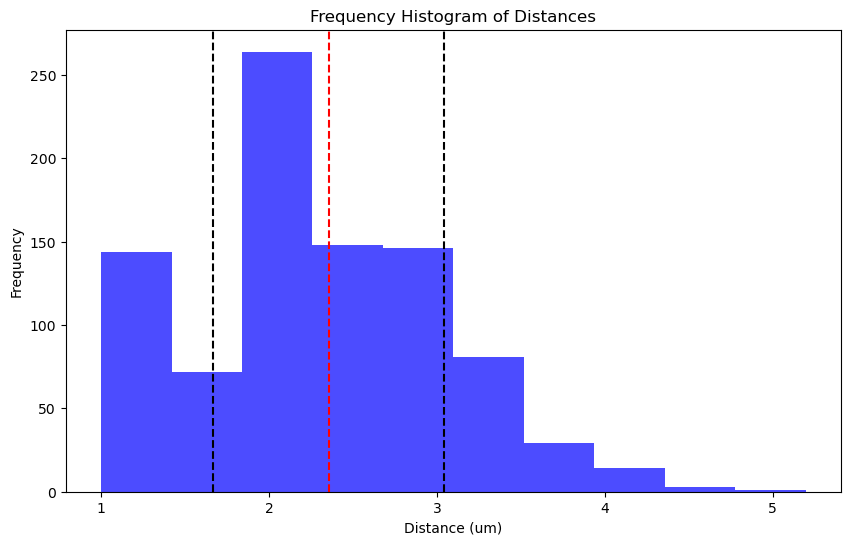

In [84]:
def distance_frequency_histogram(distances):
    '''
    '''
    
    distances = np.asarray(distances)
    distance_mean = distances.mean()
    distance_std = distances.std()

    # Plot the histogram
    plt.figure(figsize = (10,6))
    plt.hist(distances, bins=10, alpha=0.7, color='blue')
    
    plt.axvline(x=distance_mean, color='r', linestyle='--')
    plt.axvline(x=distance_mean-distance_std, color='black', linestyle='--')
    plt.axvline(x=distance_mean+distance_std, color='black', linestyle='--')


    # Add a title and labels
    plt.title('Frequency Histogram of Distances')
    plt.xlabel('Distance (um)')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

distance_frequency_histogram(distances)



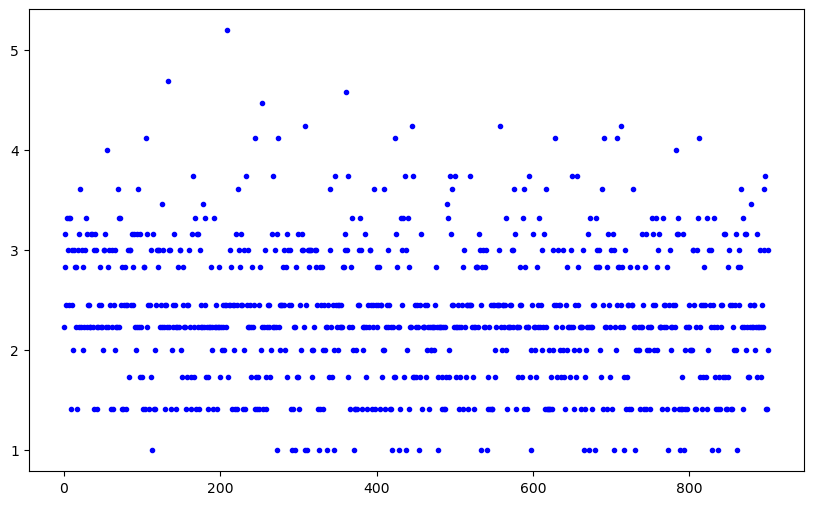

In [86]:
def distance_scatter_plot(distances):
    
    plt.figure(figsize = (10,6))
    plt.plot(distances,'b.')
    plt.show()

distance_scatter_plot(distances)

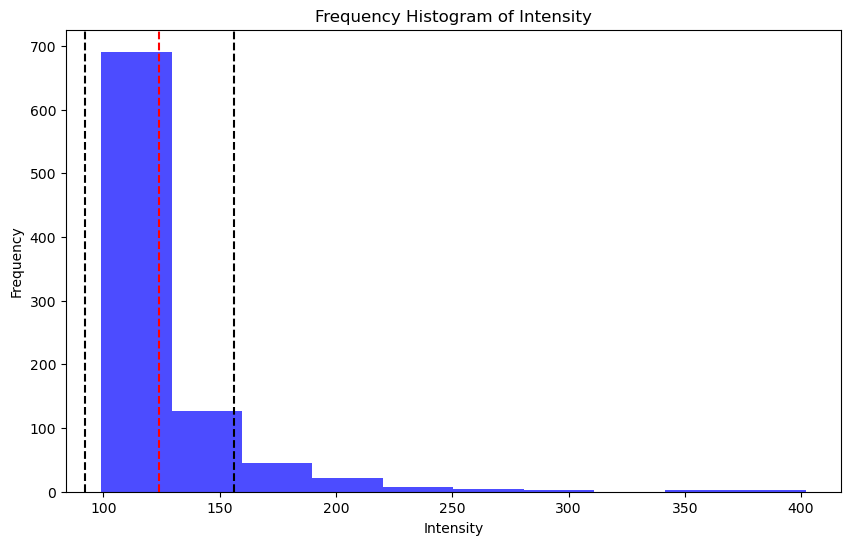

In [90]:
def plot_intensity_of_puncta(coords, small_vol):
    '''
    Plot the distribution of the intensity of the local maximum
    Inputs:
        coords: 2D numpy array, coordinates of puncta z,y,x
        small_vol: 3D numpy array, volume
    '''

    # Get the intensity of each puncta
    small_vol = np.array(small_vol)
    intensity_list = np.asarray([small_vol[x,y,z] for x,y,z in coords])
    
    # Compute the mean and standard deviation of the intensity
    intensity_mean = intensity_list.mean()
    intensity_std = intensity_list.std()
    
    # Plot the histogram
    plt.figure(figsize = (10,6))
    plt.hist(intensity_list, bins=10, alpha=0.7, color='blue')
    
    plt.axvline(x=intensity_mean, color='r', linestyle='--')
    plt.axvline(x=intensity_mean-intensity_std, color='black', linestyle='--')
    plt.axvline(x=intensity_mean+intensity_std, color='black', linestyle='--')

    plt.title('Frequency Histogram of Intensity')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

plot_intensity_of_puncta(coords, small_vol)